# Prefix

This notebook is an implementation of "A simple firing-rate model of working memory and decision-making" by Xiao-Jing Wang. Please refer to https://github.com/computational-neuroscience/wang-project/blob/master/project_instructions.pdf. 

The basic idea is that we're simulating two 'neural assemblies'. Although, there's nothing aggregative (there are no spiking neurons, just a continuously-valued firing rate equation). These two assemblies are internally reinforcing, and mutually inhibiting.

<img src="wangimage.png",width=500,height=500>

This simulation will be a model of both attention and decision.
* Attention: can a neural assembly keep its activation going after an input has stopped - so maybe it's more like short-term memory.
* Decision: given two inputs, can one assembly outcompete the other and 'win' (become the only active assembly).

In [1]:
# So, here we go...
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Firing rate equation

The firing rate equation. Leaky integrate and fire? I don't like magic numbers (excuse me, 'hyperparameters').

In [2]:
a = 270
b = 108
d = 0.154

def F(I):
    v = a*I - b
    return v / (1.0 - np.exp(-d*v))

Let's graph F(I) vs. I. Note the discontinuity at 0.4. Doesn't seem to affect simulations further on. If we have to, we can add a correction for 0.4...

/Applications/Anaconda/anaconda/envs/mlbook/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


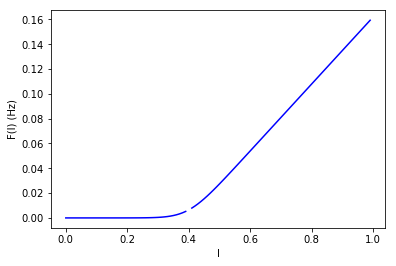

In [3]:
X = np.arange(0.0, 1.0, .01)
plt.plot(X, F(X)/1000.0, "b-")
plt.ylabel('F(I) (Hz)')
plt.xlabel('I')
plt.show()

# Synaptic Drive

I guess I don't have lots to say about this one. See plots of s vs time, below...

In [4]:
gamma = 0.641
phi = 1.0 # phi=1, except for problem 5, but there's no problem 5 in the text. Keep it anyway.
timeconstant = 100.0

def dsdt(I, s):
    f = F(I) / 1000.0
    return phi*(f*gamma*(1.0-s) - s/timeconstant)

# Input Noise

Input has noise given by 'Ornstein-Uhlenbeck process' (https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [5]:
I0 = 0.3255
rho0 = 2
noise_amplitude = 0.02

def dIbdt(Ib):
    v = -(Ib - I0) / rho0 + np.random.normal() * np.sqrt(rho0 * noise_amplitude**2.0)
    return v / rho0

Have a graph of it...

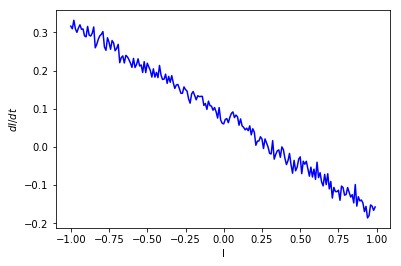

In [6]:
X = np.arange(-1, 1, .01)
y = [dIbdt(x) for x in X]
plt.plot(X, y, "b-")
plt.xlabel('I')
plt.ylabel(r'$dI/dt$')
plt.show()

# Utilities

## Generate input (mu) sequences

In [7]:
def muSequence(muChanges):
    mus = []
    for muChange in muChanges:
        muTimesteps = muChange[0]
        muValue = muChange[1]
        mus.extend([muValue] * muTimesteps)
    return mus

def muPulse3000(mu):
    return muSequence([(500, 0), (1000, mu), (1500, 0)])

## Utilities to plot things

In [8]:
def plotes(timesteps, s1, s2, label1, label2, ylabel, drawXLabelValues=True):
    plt.plot(timesteps, s1, "b-", label=label1, alpha=0.7)
    plt.plot(timesteps, s2, "r-", label=label2, alpha=0.7)
    plt.ylabel(ylabel)
    if not drawXLabelValues:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
    plt.legend(loc="upper left", fontsize=14)

def plotMus(timesteps, mu1, mu2, drawXLabelValues=True):
    plotes(timesteps, mu1, mu2, r'$\mu_1$', r'$\mu_1$', r'$\mu_i$', drawXLabelValues)
    
def plotRs(timesteps, r1, r2):
    plotes(timesteps, r1, r2, r'$r_1$', r'$r_1$', r'$r_i$')

def plotIs(timesteps, i1, i2):
    plotes(timesteps, i1, i2, r'$i_1$', r'$i_1$', r'$i_i$')
    
def plotSs(timesteps, s1, s2):
    plotes(timesteps, s1, s2, r'$s_1$', r'$s_1$', r'$s_i$')
    
def plotPhase(s1, s2, xlabel, ylabel, title):
    plt.plot(s1, s2, '-+', alpha=0.08)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
def plotRPhase(r1, r2):
    plotPhase(r1, r2, r'$r_1$', r'$r_2$', r'Phase space: $r_1$ vs $r_2$')
    
def plotSPhase(s1, s2):
    plotPhase(s1, s2, r'$s_1$', r'$s_2$', r'Phase space: $s_1$ vs $s_2$')


# Simulation Code

In [9]:
# urgh, more magic numbers
gE = 0.2609
gI = 0.0497
gext = 0.00052

def simulateit(MU1, MU2):
    np.random.seed()
    vals = []
    
    s1 = 0.1
    s2 = 0.1
    Ib1 = 0
    Ib2 = 0
    totalTime = len(MU1)
    
    for t in range(0, totalTime):
        mu1 = MU1[t] 
        mu2 = MU2[t]
        Ib1 = Ib1 + dIbdt(Ib1)
        Ib2 = Ib2 + dIbdt(Ib2)
        i1 = gE*s1 - gI*s2 + Ib1 + gext*mu1
        i2 = gE*s2 - gI*s1 + Ib2 + gext*mu2
        r1 = F(i1)
        r2 = F(i2)
        s1 = s1 + dsdt(i1, s1)
        s2 = s2 + dsdt(i2, s2)
        vals.append([t, mu1, mu2, i1, i2, r1, r2, s1, s2])
        
    return np.array(vals).transpose()

# Task 1

## Run a simulation, plot mu (the input), i1 and i2, r1 and r2, s1 and s2, and the two phase diagrams.

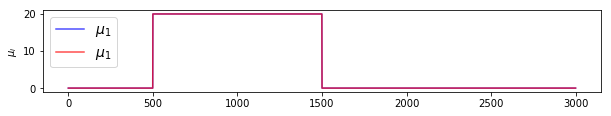

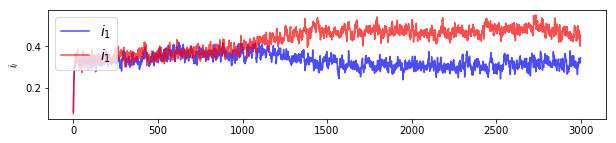

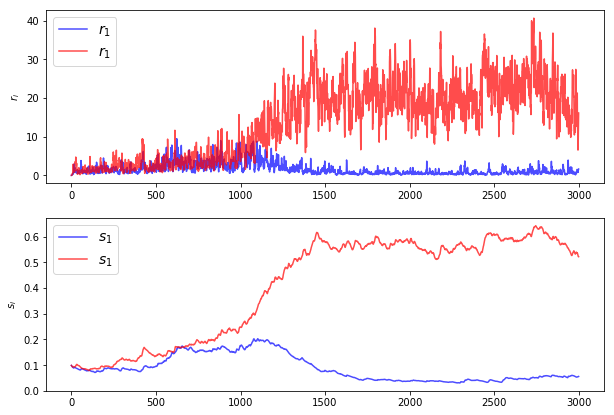

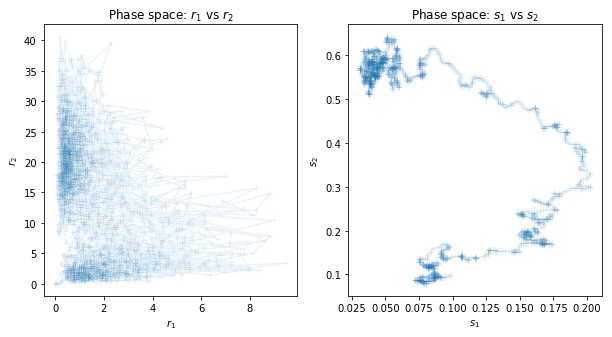

In [10]:
k = simulateit(muPulse3000(20), muPulse3000(20))

timesteps = k[0]
mu1 = k[1]
mu2 = k[2]
i1 = k[3] 
i2 = k[4] 
r1 = k[5] 
r2 = k[6] 
s1 = k[7] 
s2 = k[8] 

plt.figure(figsize=(10,1.5))
plotMus(timesteps, mu1, mu2)

plt.figure(figsize=(10,2))
plotIs(timesteps, i1, i2)

plt.figure(figsize=(10,7))
plt.subplot(211)
plotRs(timesteps, r1, r2)

plt.subplot(212)
plotSs(timesteps, s1, s2)

plt.show()


plt.figure(figsize=(10, 5))

plt.subplot(121)
plotRPhase(r1, r2)

plt.subplot(122)
plotSPhase(s1, s2)
           
plt.show()

OK, so here we can see both the 'decision' and the 'attention' ideas. Given two identical stimuli (mu1 & mu2 are the same), the two neural assemblies will battle it out, reinforcing themselves and inhibiting the other. One wins (the 'decision'), and will remain active after the stimulus ends (the 'attention').

## Coin tossing: Now do a bunch of simulations - we can see that it's about 50/50 whether each neural assembly wins

In [11]:
r1wins = 0
r2wins = 0
for i in range(0, 500):
    k = simulateit(muPulse3000(20), muPulse3000(20))
    r1 = k[5]
    r2 = k[6]
    if r1[2500] > r2[2500]:
        r1wins += 1
    else:
        r2wins += 1
print ('R1 wins: ', r1wins, '(', r1wins/500, ')   R2 wins: ', r2wins, '(', r2wins/500, ')')

R1 wins:  259 ( 0.518 )   R2 wins:  241 ( 0.482 )


I'd be really surprised at anything other than roughly 50/50...

# An aside: see what it takes to make the system 'change its mind'...

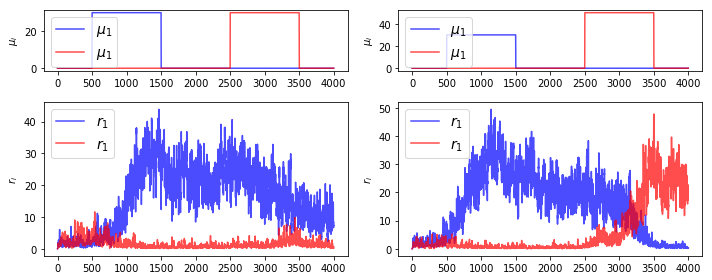

In [12]:
mu1Pulses = [muSequence([(500, 0), (1000, 30), (2500, 0)]), muSequence([(500, 0), (1000, 30), (2500, 0)])]
mu2Pulses = [muSequence([(2500, 0), (1000, 30), (1000, 0)]), muSequence([(2500, 0), (1000, 50), (1000, 0)])]

plt.figure(figsize=(10, 4))

for i in range(0, 2):
    k = simulateit(mu1Pulses[i], mu2Pulses[i])

    timesteps, mu1, mu2, r1, r2 = k[0], k[1], k[2], k[5], k[6]

    plt.subplot2grid((3, 2), (0, i), rowspan=1)
    plotMus(timesteps, mu1, mu2)

    plt.subplot2grid((3, 2), (1, i), rowspan=2)
    plotRs(timesteps, r1, r2)

plt.tight_layout()
plt.show()

Well, that's disappointing. Or is it? In the left graphs, a pulse for assembly 1 is followed by a pulse for assembly 2, but the second doesn't cause a change. In the right graph, it does, because the second pulse is stronger. Wonder if that's 'good' or 'bad'...

# Task 2: Psychometric function of coherence level

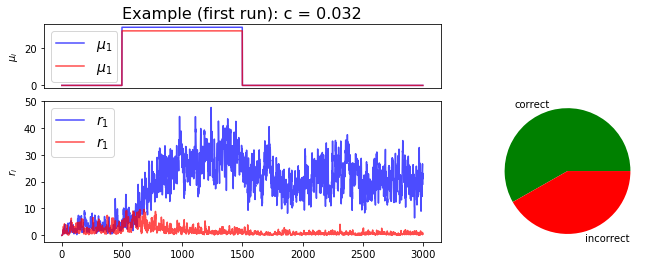

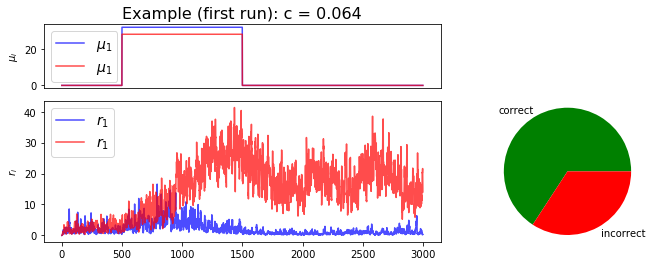

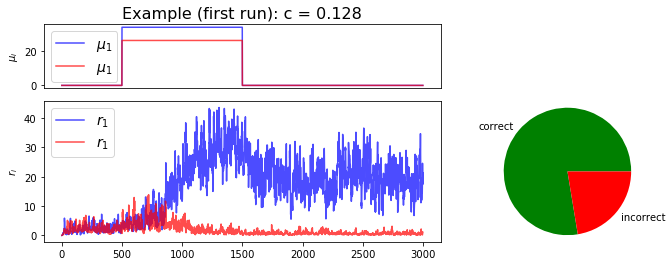

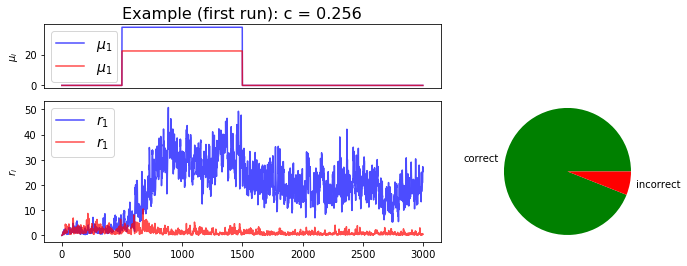

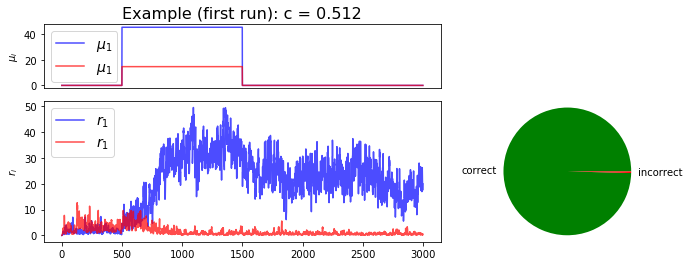

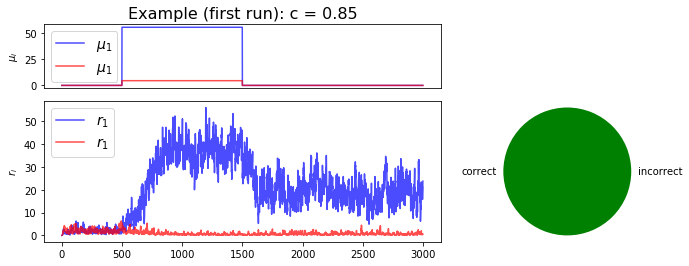

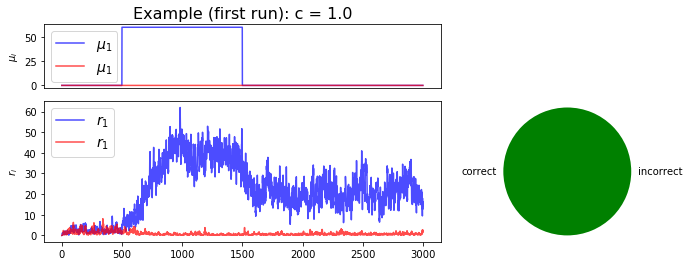

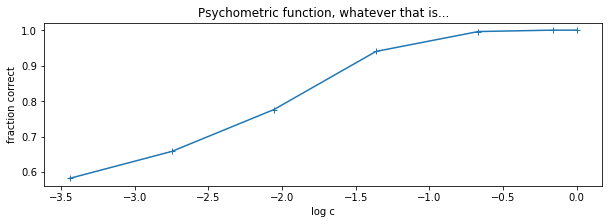

In [13]:
c_levels = [ 0.032, 0.064, 0.128, 0.256, 0.512, 0.85, 1.0 ]
fraction_correct_decisions = []
num_trials = 500
nc = len(c_levels)

for i, c in enumerate(c_levels):
    mu1v = 30.0 * (1.0 + c)
    mu2v = 30.0 * (1.0 - c)
    mu1Pulses = muSequence([(500, 0), (1000, mu1v), (1500, 0)])
    mu2Pulses = muSequence([(500, 0), (1000, mu2v), (1500, 0)])
    
    num_correct = 0
    
    for n in range(0, num_trials):
        k = simulateit(mu1Pulses, mu2Pulses)

        timesteps, mu1, mu2, r1, r2 = k[0], k[1], k[2], k[5], k[6]
        correct = (r1[2000] > r2[2000]) if mu1v > mu2v else (r1[2000] < r2[2000])
        num_correct = num_correct + (1 if correct else 0)
        
        if n == 0:
            
            plt.figure(figsize=(11,4))
            
            plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=1)
 
            plotMus(timesteps, mu1, mu2, False)
            plt.title('Example (first run): c = ' + str(c), fontsize=16)
 
            plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
            plotRs(timesteps, r1, r2)

    
    fraction_correct = num_correct / num_trials
    fraction_correct_decisions.append(fraction_correct)
     
    plt.subplot2grid((3, 3), (1, 2), colspan=1, rowspan=2)
    plt.pie([fraction_correct, 1.0-fraction_correct], colors=['g', 'r'], labels=['correct', 'incorrect'])
    plt.axis('equal')
   
plt.show()
    
plt.figure(figsize=(10,3))

log_c_levels = np.log(c_levels)
plt.plot(log_c_levels, fraction_correct_decisions, "+-")
plt.ylabel('fraction correct')
plt.xlabel('log c')
plt.title('Psychometric function, whatever that is...')
plt.show()